# Graph Data Science Workshop

The objective of this workshop is to serve as a guide for Data Analysts, Data Scientists and Machine Learning enthusiasts, so they can jump into Graph Data Science.

For a detailed study we recommend the book:

Graph Machine Learning: Take graph data to the next level by applying machine learning techniques and algorithms, ISBN 1800204493, ISBN-13 9781800204492 (A. Marzullo, E. Deusebio, C. Stamile (2021))

In [1]:
!pip install networkx==2.1
!pip install matplotlib==2.2.3
!pip install node2vec==0.3.3
!pip install gensim==3.8.3
!pip install xgboost==1.4.2

In [2]:
import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import hashlib
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm

from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, EdgeEmbedder

import networkx as nx
from networkx.algorithms import community

import xgboost as xgb
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(9, 6)})

%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

# Graph Basics

Graphs are mathematical structures that are used for describing relations between entities
and are used almost everywhere. For example, social networks are graphs, where users
are connected depending on whether one user "follows" the updates of another user. They
can be used for representing maps, where cities are linked through streets. Graphs can
describe biological structures, web pages, and even the progression of neurodegenerative
diseases.


Graph theory, the study of graphs, has received major interest for years, leading people
to develop algorithms, identify properties, and define mathematical models to better
understand complex behaviors.

In [3]:
def draw_graph(G, pos_nodes, node_names={}, node_size=50, plot_weight=False):
    
    nx.draw(G, pos_nodes, with_labels=False, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    
    if plot_weight:
        pos_attrs = {}
        for node, coords in pos_nodes.items():
            pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
        nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
        edge_labels=dict([((a,b,),d["weight"]) for a,b,d in G.edges(data=True)])
        nx.draw_networkx_edge_labels(G, pos_nodes, edge_labels=edge_labels)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])

## Undirected Graph

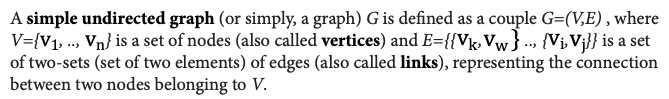

In [4]:
G = nx.Graph()
V = {'Dublin', 'Paris', 'Milan', 'Rome'}
E = [('Milan','Dublin'), ('Milan','Paris'), ('Paris','Dublin'), ('Milan','Rome')]
G.add_nodes_from(V)
G.add_edges_from(E)

In [5]:
G

In [6]:
print(f"Graph Order: {G.number_of_nodes()}")
print(f"Graph Size: {G.number_of_edges()}")
print(f"Nodes: {G.nodes}")
print(f"Edges: {G.edges}")
print(f"Degree for nodes: { {v: G.degree(v) for v in G.nodes} }")
print(f"Neighbors for nodes: { {v: list(G.neighbors(v)) for v in G.nodes} }")

Graph Order: 4
Graph Size: 4
Nodes: ['Dublin', 'Rome', 'Milan', 'Paris']
Edges: [('Dublin', 'Milan'), ('Dublin', 'Paris'), ('Rome', 'Milan'), ('Milan', 'Paris')]
Degree for nodes: {'Dublin': 2, 'Rome': 1, 'Milan': 3, 'Paris': 2}
Neighbors for nodes: {'Dublin': ['Milan', 'Paris'], 'Rome': ['Milan'], 'Milan': ['Dublin', 'Paris', 'Rome'], 'Paris': ['Milan', 'Dublin']}


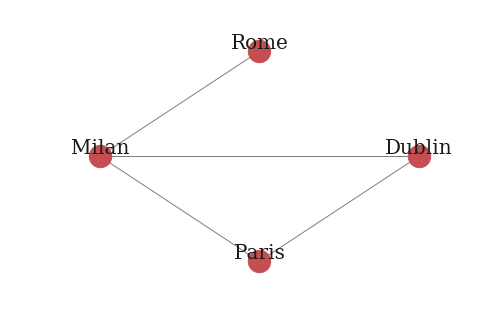

In [7]:
draw_graph(G, pos_nodes=nx.shell_layout(G), node_size=500)

### Add Nodes and Edges

Graph Order: 6
Graph Size: 6
Nodes: ['Dublin', 'Rome', 'Milan', 'Paris', 'Madrid', 'London']
Edges: [('Dublin', 'Milan'), ('Dublin', 'Paris'), ('Rome', 'Milan'), ('Rome', 'London'), ('Milan', 'Paris'), ('Paris', 'Madrid')]
Degree for nodes: {'Dublin': 2, 'Rome': 2, 'Milan': 3, 'Paris': 3, 'Madrid': 1, 'London': 1}
Neighbors for nodes: {'Dublin': ['Milan', 'Paris'], 'Rome': ['Milan', 'London'], 'Milan': ['Dublin', 'Paris', 'Rome'], 'Paris': ['Milan', 'Dublin', 'Madrid'], 'Madrid': ['Paris'], 'London': ['Rome']}


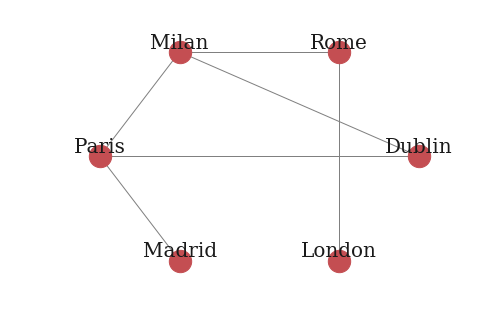

In [8]:
new_nodes = {'London', 'Madrid'}
new_edges = [('London','Rome'), ('Madrid','Paris')]
G.add_nodes_from(new_nodes)
G.add_edges_from(new_edges)

print(f"Graph Order: {G.number_of_nodes()}")
print(f"Graph Size: {G.number_of_edges()}")
print(f"Nodes: {G.nodes}")
print(f"Edges: {G.edges}")
print(f"Degree for nodes: { {v: G.degree(v) for v in G.nodes} }")
print(f"Neighbors for nodes: { {v: list(G.neighbors(v)) for v in G.nodes} }")

draw_graph(G, pos_nodes=nx.shell_layout(G), node_size=500)

### Remove Nodes

Graph Order: 4
Graph Size: 4
Nodes: ['Dublin', 'Rome', 'Milan', 'Paris']
Edges: [('Dublin', 'Milan'), ('Dublin', 'Paris'), ('Rome', 'Milan'), ('Milan', 'Paris')]
Degree for nodes: {'Dublin': 2, 'Rome': 1, 'Milan': 3, 'Paris': 2}
Neighbors for nodes: {'Dublin': ['Milan', 'Paris'], 'Rome': ['Milan'], 'Milan': ['Dublin', 'Paris', 'Rome'], 'Paris': ['Milan', 'Dublin']}


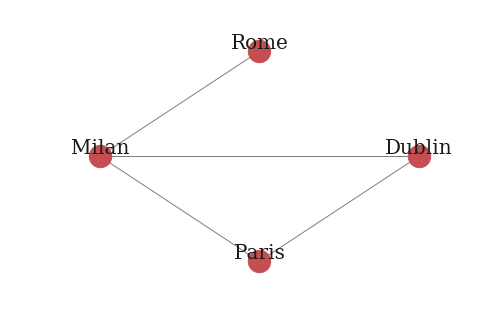

In [9]:
node_remove = {'London', 'Madrid'}
G.remove_nodes_from(node_remove)

print(f"Graph Order: {G.number_of_nodes()}")
print(f"Graph Size: {G.number_of_edges()}")
print(f"Nodes: {G.nodes}")
print(f"Edges: {G.edges}")
print(f"Degree for nodes: { {v: G.degree(v) for v in G.nodes} }")
print(f"Neighbors for nodes: { {v: list(G.neighbors(v)) for v in G.nodes} }")

draw_graph(G, pos_nodes=nx.shell_layout(G), node_size=500)

### Remove Edges

Graph Order: 4
Graph Size: 2
Nodes: ['Dublin', 'Rome', 'Milan', 'Paris']
Edges: [('Dublin', 'Paris'), ('Rome', 'Milan')]
Degree for nodes: {'Dublin': 1, 'Rome': 1, 'Milan': 1, 'Paris': 1}
Neighbors for nodes: {'Dublin': ['Paris'], 'Rome': ['Milan'], 'Milan': ['Rome'], 'Paris': ['Dublin']}


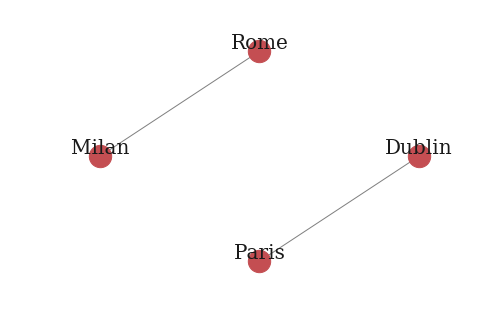

In [10]:
node_edges = [('Milan','Dublin'), ('Milan','Paris')]
G.remove_edges_from(node_edges)

print(f"Graph Order: {G.number_of_nodes()}")
print(f"Graph Size: {G.number_of_edges()}")
print(f"Nodes: {G.nodes}")
print(f"Edges: {G.edges}")
print(f"Degree for nodes: { {v: G.degree(v) for v in G.nodes} }")
print(f"Neighbors for nodes: { {v: list(G.neighbors(v)) for v in G.nodes} }")

draw_graph(G, pos_nodes=nx.shell_layout(G), node_size=500)

## Directed Graph

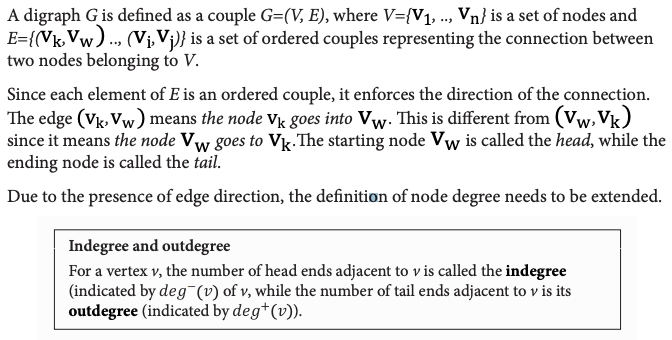

Graph Order: 4
Graph Size: 4
Nodes: ['Dublin', 'Rome', 'Milan', 'Paris']
Edges: [('Milan', 'Dublin'), ('Milan', 'Rome'), ('Paris', 'Milan'), ('Paris', 'Dublin')]
Degree for nodes: {'Dublin': 2, 'Rome': 1, 'Milan': 3, 'Paris': 2}
Neighbors for nodes: {'Dublin': [], 'Rome': [], 'Milan': ['Dublin', 'Rome'], 'Paris': ['Milan', 'Dublin']}


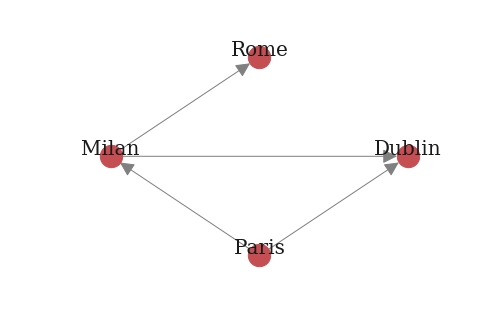

In [11]:
G = nx.DiGraph()
V = {'Dublin', 'Paris', 'Milan', 'Rome'}
E = [('Milan','Dublin'), ('Paris','Milan'), ('Paris','Dublin'), ('Milan','Rome')]
G.add_nodes_from(V)
G.add_edges_from(E)

print(f"Graph Order: {G.number_of_nodes()}")
print(f"Graph Size: {G.number_of_edges()}")
print(f"Nodes: {G.nodes}")
print(f"Edges: {G.edges}")
print(f"Degree for nodes: { {v: G.degree(v) for v in G.nodes} }")
print(f"Neighbors for nodes: { {v: list(G.neighbors(v)) for v in G.nodes} }")

draw_graph(G, pos_nodes=nx.shell_layout(G), node_size=500)

## Weighted Directed Graph

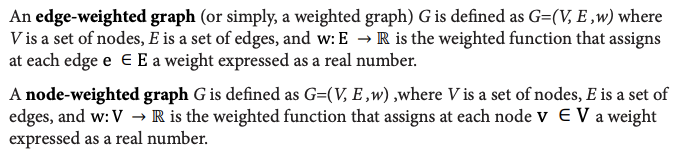

Graph Order: 4
Graph Size: 4
Nodes: ['Dublin', 'Rome', 'Milan', 'Paris']
Edges: [('Milan', 'Rome', 0), ('Milan', 'Dublin', 0), ('Paris', 'Dublin', 0), ('Paris', 'Milan', 0)]
Degree for nodes: {'Dublin': 2, 'Rome': 1, 'Milan': 3, 'Paris': 2}
Neighbors for nodes: {'Dublin': [], 'Rome': [], 'Milan': ['Rome', 'Dublin'], 'Paris': ['Dublin', 'Milan']}


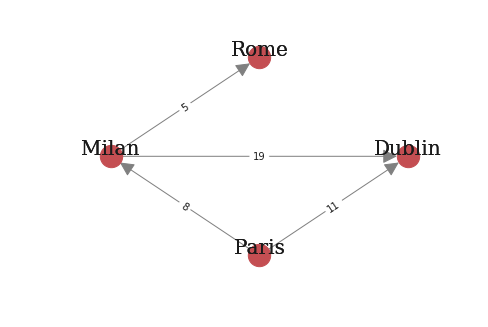

In [12]:
G = nx.MultiDiGraph()
V = {'Paris', 'Dublin','Milan', 'Rome'}
E = [ ('Paris','Dublin', 11), ('Paris','Milan', 8),
     ('Milan','Rome', 5),('Milan','Dublin', 19)]
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

print(f"Graph Order: {G.number_of_nodes()}")
print(f"Graph Size: {G.number_of_edges()}")
print(f"Nodes: {G.nodes}")
print(f"Edges: {G.edges}")
print(f"Degree for nodes: { {v: G.degree(v) for v in G.nodes} }")
print(f"Neighbors for nodes: { {v: list(G.neighbors(v)) for v in G.nodes} }")

draw_graph(G, pos_nodes=nx.shell_layout(G), node_size=500, plot_weight=True)

# Let's build some Graphs with real Data

## Load Dataset

Dataset generated with random sampling.

In [13]:
df_trx = pd.read_parquet('data/dataset_20220105_153428.parquet')

In [14]:
df_trx.head()

,trx_id,created_date,amt,hash,card_holder_hash,user_email_hash,is_fraud,cbk_date_created,amt_cbk
0,58232584,2020-01-14 15:49:55,26.84,26003ecd86565467ec384e15fd7f20e22a61dbaa109687...,c5eb1bf2c5186dcf0b666ce22bc11d82c6023dc63673dd...,651ed4ad6ae79beb7fcf19ce616de3e9d1fe1f749de7a4...,0,NaT,0.0
1,65957973,2020-02-19 00:06:36,4.43,ecb8705d4298321527f850da457f18b0e70814354e588c...,280c26070fadf68639172163036d5f7cbb2421565ea105...,30d332a51aa8e6be35301e323f6d7adacf6a78b89d47ce...,0,NaT,0.0
2,68511121,2020-02-29 15:45:58,43.23,108a4cf43b3649b07744f01ae3788d23e3fbf3e8eb4a35...,87c100ab345e7d87934896d47267d2cff359a0bd7e2a48...,e95f92d5fd98d7ba95c148ee17f17023551734fd542a0d...,0,NaT,0.0
3,68992833,2020-03-02 10:59:05,2.16,13bfdf285ed294dda86ce3dd14cdf4cb1f2a3d9176b27c...,a0c98f149bdd6cfe2fe486babf2e99c1906bbf07be92f8...,28ee1f28f93bdde2bcb86a2d41deb85f69609f637efc08...,0,NaT,0.0
4,70421500,2020-03-08 05:58:06,1.04,754dbd4982b432da55fa880b1656176def6396b3f762e3...,56522559a497e1bfeb156396aedc9b94d8fc43247f4eaf...,81ce9e5df0f9bb5a99dec39ce61b86ed66f826e230de49...,0,NaT,0.0


In [15]:
df_trx.is_fraud.value_counts()

0    21561
1     1422
Name: is_fraud, dtype: int64

### Knowledge Graphs

Knowledge graphs are the foundation of GDS and offer a way to streamline workflows, automate responses, and scale intelligent decisions. 

At a high level, knowledge graphs are interlinked sets of data points and describe real-world entities, facts, or things and their relationship with each other in a human-understandable form. Unlike a simple knowledge base with flat structures and static content, a knowledge graph acquires and integrates adjacent information by using data relationships to derive new knowledge.

In this example, we will build our graph using as nodes

- trx_id
- hash
- card_holder_hash
- user_email_hash

This way it will link transactions by customer data

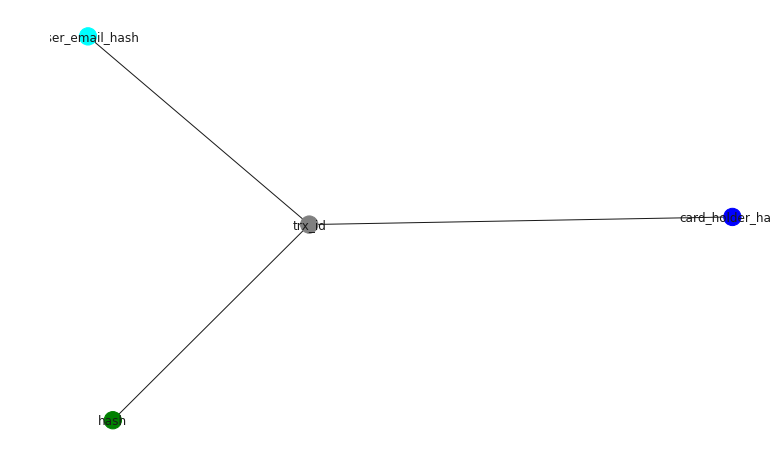

In [16]:
G = nx.Graph()
V = {'trx_id', 'hash', 'card_holder_hash', 'user_email_hash'}
E = [('trx_id','hash'), ('trx_id','card_holder_hash'), ('trx_id','user_email_hash')]
G.add_nodes_from(V)
G.add_edges_from(E)

plt.figure(figsize=(10, 6))
nx.draw(G, node_color=['blue', 'grey', 'cyan', 'green'], with_labels=True)
plt.show()

## Graph Functions

In [17]:
def build_graph(df, pivot_column, edge_columns, attr_columns, identify_subgraphs=True):
    
    """
    Function to build graph from dataframe
    :param df: Dataframe with data to build graph
    :param pivot_column: pivot column
    :param edge_columns: list with other nodes to build graph
    :param attr_columns: list with attributes to add
    :param identify_subgraphs: flag True to return subgraphs
    :return G, sG: Complete graph and subgraphs objects
    """

    df_edge = pd.DataFrame()
    
    for col in edge_columns:
        df_edge_temp = df[[pivot_column, col]]
        df_edge_temp.columns = ['source', 'target']
        df_edge_temp = df_edge_temp[~df_edge_temp.source.isnull()]
        df_edge_temp = df_edge_temp[~df_edge_temp.target.isnull()]
        df_edge_temp.source = pivot_column + '-' + df_edge_temp.source.astype('str')
        df_edge_temp.target = col + '-' + df_edge_temp.target.astype('str')
        df_edge = df_edge.append(df_edge_temp, ignore_index=True)
    df_edge = df_edge.drop_duplicates()

    # 1. Create graph
    G = nx.from_pandas_edgelist(
        df_edge, 
        source='source', 
        target='target'
    )
    
    # 2. Add Attributes
    # Dataframe with attributes to add
    df_attr = df[[pivot_column] + attr_columns]
    df_attr[pivot_column] = pivot_column + '-' + df_attr[pivot_column].astype('str')

    # Build dictionary to add attributes
    node_attr = df_attr[[pivot_column] + attr_columns].set_index(pivot_column).to_dict('index')

    # Set attributes to nodes
    nx.set_node_attributes(G, node_attr)

    # 3. Identify subgraphs
    if identify_subgraphs:
        sG = nx.connected_component_subgraphs(G)
        return G, sG
    else:
        return G

In [18]:
def plot_graph(data, edge_columns, pivot_column, edge_colors, pivot_color, x_size=20, y_size=15, title='Graph'):
    
    """
    Function to plot graph from dataframe
    :param data: Dataframe with data to build graph
    :param edge_columns: list with other nodes to build graph
    :param pivot_column: pivot column
    :param edge_colors: list edges colors
    :param pivot_colors: list pivot colors
    :param x_size: plot x_size
    :param y_size: plot y_size
    :param title: plot title
    :return df_edge: dataframe with edges used to plot graph
    """
    
    df_edge = pd.DataFrame()
    
    for col in edge_columns:
        df_edge_temp = data[[pivot_column, col]]
        df_edge_temp.columns = ['source', 'target']
        df_edge_temp.source = pivot_column + '-' + df_edge_temp.source.astype('str')
        df_edge_temp.target = col + '-' + df_edge_temp.target.astype('str')
        df_edge = df_edge.append(df_edge_temp, ignore_index=True)
    df_edge = df_edge.drop_duplicates()
    
    # PLOT GRAPH AND SAVE.png
    plt.figure(figsize=(x_size, y_size))

    # 1. Create graph
    G = nx.from_pandas_edgelist(
        df_edge, 
        source='source', 
        target='target'
    )

    # 2. Create a layout for our nodes 
    layout = nx.spring_layout(G,iterations=50)
    
    # 3. Get Edges List
    list_source = list(df_edge['source'].unique())
    list_target = list(df_edge['target'].unique())
    
    edges_dict = {}
    
    for col in edge_columns:
        edges_dict[col] = [x for x in list_target if x.startswith(col+'-')]
        
        
    # 4. DRAW Nodes
    nx.draw_networkx_nodes(G, 
                           layout, 
                           nodelist=list_source, 
                           node_color=pivot_color, 
                           node_size=100)
    
    i = 1
    for col in edge_columns:
        if 'device' in col:
            
            node_size = 200
        else:
            node_size = 200
        nx.draw_networkx_nodes(G, 
                           layout, 
                           nodelist=edges_dict[col], 
                           node_color=edge_colors[i-1], 
                           node_size=node_size)
        i+=1
    
    # 5. DRAW EDGES
    nx.draw_networkx_edges(G, 
                           layout, 
                           width=1, 
                           edge_color='gainsboro')
    plt.axis('off')
    plt.title(title)
    
    # 6. Add Legends
    handles, labels = plt.gca().get_legend_handles_labels()
    patch = mpatches.Patch(color=pivot_color, label=pivot_column)
    handles.append(patch) 
    i = 1
    for col in edge_columns: 
        patch = mpatches.Patch(color=edge_colors[i-1], label=col)
        handles.append(patch)
        i+=1

    # 7. Plot the legend
    plt.legend(handles=handles, loc='upper left')
    
    return df_edge

## Build Graph from pandas dataframe

In [19]:
df_trx.head()

,trx_id,created_date,amt,hash,card_holder_hash,user_email_hash,is_fraud,cbk_date_created,amt_cbk
0,58232584,2020-01-14 15:49:55,26.84,26003ecd86565467ec384e15fd7f20e22a61dbaa109687...,c5eb1bf2c5186dcf0b666ce22bc11d82c6023dc63673dd...,651ed4ad6ae79beb7fcf19ce616de3e9d1fe1f749de7a4...,0,NaT,0.0
1,65957973,2020-02-19 00:06:36,4.43,ecb8705d4298321527f850da457f18b0e70814354e588c...,280c26070fadf68639172163036d5f7cbb2421565ea105...,30d332a51aa8e6be35301e323f6d7adacf6a78b89d47ce...,0,NaT,0.0
2,68511121,2020-02-29 15:45:58,43.23,108a4cf43b3649b07744f01ae3788d23e3fbf3e8eb4a35...,87c100ab345e7d87934896d47267d2cff359a0bd7e2a48...,e95f92d5fd98d7ba95c148ee17f17023551734fd542a0d...,0,NaT,0.0
3,68992833,2020-03-02 10:59:05,2.16,13bfdf285ed294dda86ce3dd14cdf4cb1f2a3d9176b27c...,a0c98f149bdd6cfe2fe486babf2e99c1906bbf07be92f8...,28ee1f28f93bdde2bcb86a2d41deb85f69609f637efc08...,0,NaT,0.0
4,70421500,2020-03-08 05:58:06,1.04,754dbd4982b432da55fa880b1656176def6396b3f762e3...,56522559a497e1bfeb156396aedc9b94d8fc43247f4eaf...,81ce9e5df0f9bb5a99dec39ce61b86ed66f826e230de49...,0,NaT,0.0


In [20]:
# Build graph
G, sG = build_graph(
    df_trx, 
    'trx_id', 
    ['hash','card_holder_hash', 'user_email_hash'], 
    ['is_fraud', 'amt'], 
    True
)

In [21]:
G

In [22]:
list(G.nodes)[:10]

['trx_id-58232584',
 'hash-26003ecd86565467ec384e15fd7f20e22a61dbaa10968731e5272eb3f87a546e',
 'trx_id-65957973',
 'hash-ecb8705d4298321527f850da457f18b0e70814354e588c377b0e7832a44c1436',
 'trx_id-68511121',
 'hash-108a4cf43b3649b07744f01ae3788d23e3fbf3e8eb4a3542bd0efb7a1f9fa474',
 'trx_id-68992833',
 'hash-13bfdf285ed294dda86ce3dd14cdf4cb1f2a3d9176b27cf56fe359d101f966c0',
 'trx_id-70421500',
 'hash-754dbd4982b432da55fa880b1656176def6396b3f762e3ae3a7dd9818b574d3e']

In [23]:
list(G.edges)[:10]

[('trx_id-58232584',
  'hash-26003ecd86565467ec384e15fd7f20e22a61dbaa10968731e5272eb3f87a546e'),
 ('trx_id-58232584',
  'card_holder_hash-c5eb1bf2c5186dcf0b666ce22bc11d82c6023dc63673dd63f0f870aca9c16684'),
 ('trx_id-58232584',
  'user_email_hash-651ed4ad6ae79beb7fcf19ce616de3e9d1fe1f749de7a424a3520d21f48d3485'),
 ('trx_id-65957973',
  'hash-ecb8705d4298321527f850da457f18b0e70814354e588c377b0e7832a44c1436'),
 ('trx_id-65957973',
  'card_holder_hash-280c26070fadf68639172163036d5f7cbb2421565ea1054477f8edda35cd7ce3'),
 ('trx_id-65957973',
  'user_email_hash-30d332a51aa8e6be35301e323f6d7adacf6a78b89d47ce89b3dbbe42ed640d43'),
 ('hash-ecb8705d4298321527f850da457f18b0e70814354e588c377b0e7832a44c1436',
  'trx_id-67927428'),
 ('hash-ecb8705d4298321527f850da457f18b0e70814354e588c377b0e7832a44c1436',
  'trx_id-113499160'),
 ('hash-ecb8705d4298321527f850da457f18b0e70814354e588c377b0e7832a44c1436',
  'trx_id-131371482'),
 ('hash-ecb8705d4298321527f850da457f18b0e70814354e588c377b0e7832a44c1436',
  't

In [24]:
G.nodes['trx_id-58232584']

{'is_fraud': 0, 'amt': 26.84}

In [25]:
sG

<generator object connected_component_subgraphs at 0x7f6ea2c7dfc0>

### Plot graph

Plotting entire graph is not recommended, it is a good practice identify communities and plot them instead.

Below you will see a general graph sampling, you will see some components that are not connected, we call these communities.

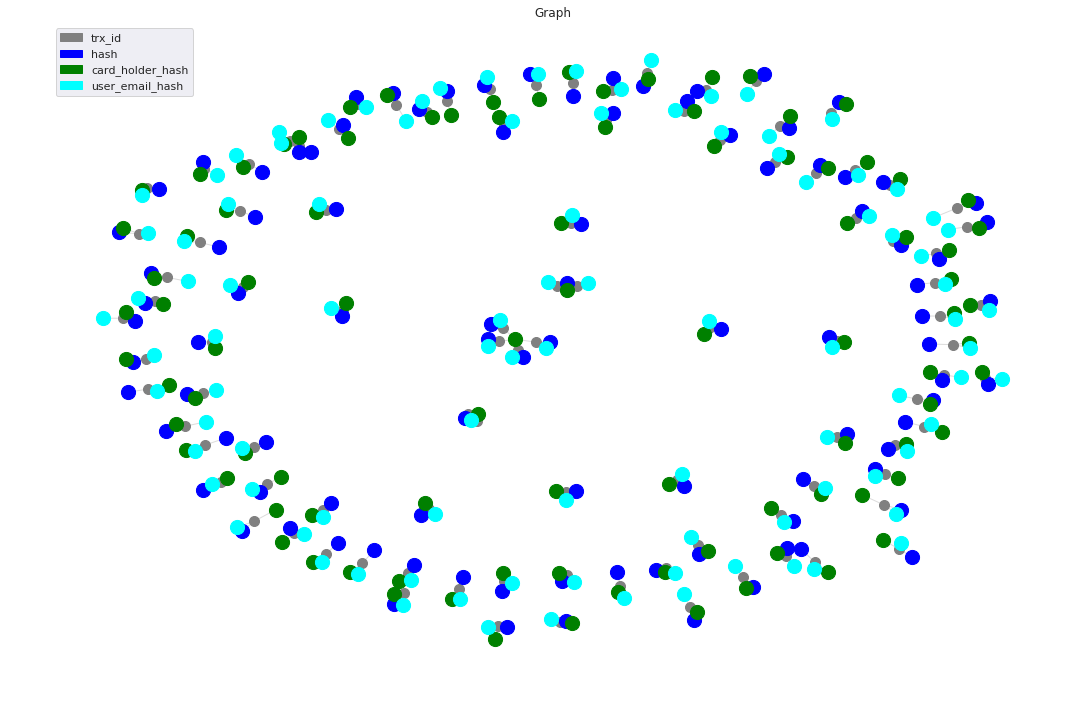

In [26]:
edge_columns = ['hash','card_holder_hash', 'user_email_hash']
edge_colors = ['blue','green','cyan']
pivot_column = 'trx_id'
pivot_color = 'gray'

_ = plot_graph(
    df_trx.head(100), 
    edge_columns, 
    pivot_column, 
    edge_colors, 
    pivot_color, 
    x_size=18, 
    y_size=12
)

## Graph Analytics

Graph Analytics consists of understanding the network better and answer specific questions based on relationships and topology.

You’re often trying to infer meaning based on the network structure: finding clusters, identifying influential nodes, evaluating different pathways.

### Communities

Detecting communities in a network is one of the most important tasks in network analysis. 

In a large scale network, such as an online social network, we could have millions of nodes and edges. 

Detecting communities in such networks becomes a herculean task.

### Community Detection by Subgraphs

In [27]:
# Dictionary to store transaction_id and community_id mapping
communities = {}

# Community incremental id
i = 0

# Iterate over each subgraph and extract transaction_id
for subgraph in sG:
    sG_nodes = subgraph.nodes
    sG_nodes = [int(node.replace('trx_id-','')) for node in sG_nodes if node.startswith('trx_id')]
    comminities_temp = dict.fromkeys(sG_nodes, i)
    communities.update(comminities_temp)
    i+=1
    
# Add community_id to our trx dataframe
df_trx['community_id'] = df_trx.trx_id.map(communities)

In [28]:
df_trx.head()

,trx_id,created_date,amt,hash,card_holder_hash,user_email_hash,is_fraud,cbk_date_created,amt_cbk,community_id
0,58232584,2020-01-14 15:49:55,26.84,26003ecd86565467ec384e15fd7f20e22a61dbaa109687...,c5eb1bf2c5186dcf0b666ce22bc11d82c6023dc63673dd...,651ed4ad6ae79beb7fcf19ce616de3e9d1fe1f749de7a4...,0,NaT,0.0,0
1,65957973,2020-02-19 00:06:36,4.43,ecb8705d4298321527f850da457f18b0e70814354e588c...,280c26070fadf68639172163036d5f7cbb2421565ea105...,30d332a51aa8e6be35301e323f6d7adacf6a78b89d47ce...,0,NaT,0.0,1
2,68511121,2020-02-29 15:45:58,43.23,108a4cf43b3649b07744f01ae3788d23e3fbf3e8eb4a35...,87c100ab345e7d87934896d47267d2cff359a0bd7e2a48...,e95f92d5fd98d7ba95c148ee17f17023551734fd542a0d...,0,NaT,0.0,2
3,68992833,2020-03-02 10:59:05,2.16,13bfdf285ed294dda86ce3dd14cdf4cb1f2a3d9176b27c...,a0c98f149bdd6cfe2fe486babf2e99c1906bbf07be92f8...,28ee1f28f93bdde2bcb86a2d41deb85f69609f637efc08...,0,NaT,0.0,3
4,70421500,2020-03-08 05:58:06,1.04,754dbd4982b432da55fa880b1656176def6396b3f762e3...,56522559a497e1bfeb156396aedc9b94d8fc43247f4eaf...,81ce9e5df0f9bb5a99dec39ce61b86ed66f826e230de49...,0,NaT,0.0,4


### Community stats

In this particular case we are interested on identifying fraudulent communities so there are a couple of metrics to do so, for instance Chargeback ratio in quantity and amount.

Also count the number of unique hash, card_holder and email within the community.

In [29]:
# Community stats
df_community = df_trx.groupby('community_id').agg(
    {
        'trx_id':'count', 
        'is_fraud':'sum', 
        'amt':'sum', 
        'amt_cbk':'sum',
        'hash':'nunique',
        'card_holder_hash':'nunique',
        'user_email_hash':'nunique'
    }
)

# Calculate Chargeback ratios
df_community.reset_index(inplace=True)
df_community.columns = ['community_id', 'q_trx', 'q_cbk', 'amt_trx', 'amt_cbk', 'q_dist_hash', 'q_dist_card_holder', 'q_dist_user_email']
df_community['ratio_cbk_q'] = round(df_community.q_cbk / df_community.q_trx, 2)
df_community['ratio_cbk_amt'] = round(df_community.amt_cbk / df_community.amt_trx, 2)
df_community = df_community[['community_id', 'q_dist_hash', 'q_dist_card_holder', 'q_dist_user_email', 'q_trx', 'q_cbk', 'ratio_cbk_q', 'amt_trx', 'amt_cbk', 'ratio_cbk_amt']]

# Keep communities with at least 10 transactions
df_community = df_community[df_community.q_trx > 9]

In [30]:
df_community.head()

,community_id,q_dist_hash,q_dist_card_holder,q_dist_user_email,q_trx,q_cbk,ratio_cbk_q,amt_trx,amt_cbk,ratio_cbk_amt
1,1,1,1,1,15,0,0.0,80.45,0.0,0.0
2,2,5,2,5,115,0,0.0,1252.57,0.0,0.0
3,3,1,1,4,111,0,0.0,1958.26,0.0,0.0
7,7,5,3,1,12,0,0.0,53.89,0.0,0.0
10,10,2,2,3,13,0,0.0,66.16,0.0,0.0


In [31]:
df_community.describe()

,community_id,q_dist_hash,q_dist_card_holder,q_dist_user_email,q_trx,q_cbk,ratio_cbk_q,amt_trx,amt_cbk,ratio_cbk_amt
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,879.492308,3.026923,1.784615,2.792308,34.069231,1.069231,0.046769,655.867038,127.617077,0.055115
std,971.605909,3.276694,1.364099,6.754602,48.927918,5.028396,0.186559,3499.334582,1192.975268,0.209943
min,1.000000,1.000000,0.000000,0.000000,10.000000,0.000000,0.000000,9.000000,0.000000,0.000000
25%,195.750000,1.000000,1.000000,1.000000,12.000000,0.000000,0.000000,66.070000,0.000000,0.000000
50%,522.500000,2.000000,1.000000,2.000000,20.000000,0.000000,0.000000,135.120000,0.000000,0.000000
75%,1176.750000,3.000000,2.000000,2.000000,34.000000,0.000000,0.000000,347.805000,0.000000,0.000000
max,5799.000000,30.000000,10.000000,82.000000,544.000000,58.000000,1.000000,52061.190000,17677.790000,1.000000


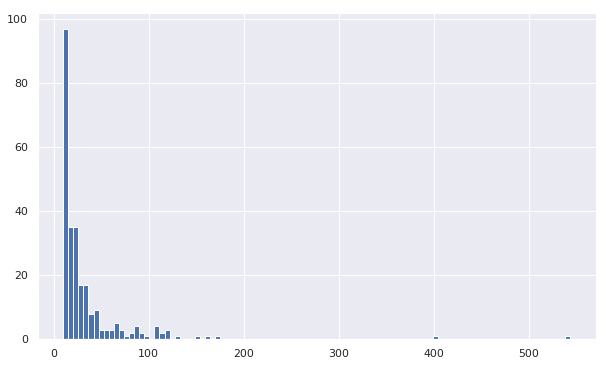

In [32]:
plt.figure(figsize=(10, 6))

df_community.q_trx.hist(bins = 100)

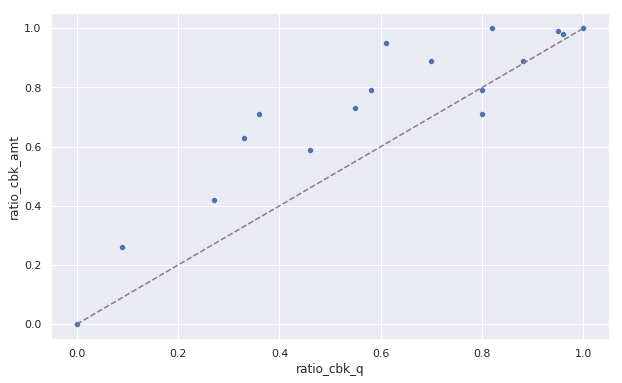

In [33]:
plt.figure(figsize=(10, 6))

# Plotting
g = sns.scatterplot(
    x = "ratio_cbk_q", 
    y = "ratio_cbk_amt", 
    data = df_community,
    palette = "Blues_d"
)
g = sns.lineplot(
    x = np.arange(0,1.1,.1), 
    y = np.arange(0,1.1,.1), 
    linestyle = '--', 
    color = 'grey'
)

Let's isolate communities with high cbk rate so we can analyse one of them.

In [34]:
df_community[
    (df_community.ratio_cbk_q > 0.5)
].sort_values('q_trx', ascending=False)

,community_id,q_dist_hash,q_dist_card_holder,q_dist_user_email,q_trx,q_cbk,ratio_cbk_q,amt_trx,amt_cbk,ratio_cbk_amt
404,404,30,1,56,61,58,0.95,17814.64,17677.79,0.99
124,124,1,1,1,33,20,0.61,279.17,265.21,0.95
291,291,2,2,3,26,15,0.58,261.01,205.98,0.79
239,239,2,2,2,24,21,0.88,693.39,617.31,0.89
559,559,12,2,17,23,22,0.96,6797.38,6692.58,0.98
984,984,2,1,1,23,16,0.70,1072.74,959.15,0.89
527,527,7,1,9,15,12,0.80,4368.73,3464.92,0.79
810,810,1,1,2,12,12,1.00,81.38,81.38,1.00
479,479,1,1,2,11,6,0.55,145.31,106.06,0.73
588,588,1,1,3,11,9,0.82,297.87,296.78,1.00


community_id 758 seems interesting, it has 80% of chargeback rate and is using several cards and user email.

In [35]:
df_trx[df_trx.community_id == 758]

,trx_id,created_date,amt,hash,card_holder_hash,user_email_hash,is_fraud,cbk_date_created,amt_cbk,community_id
1007,227535772,2020-10-25 16:47:51,5.16,15d8fbe308ddcb48593c74476835d5a99036e3aed1442e...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,35cd752eb8d7d9a08289f4269b4bc9df1242fef52c0529...,1,2020-11-13 14:29:29,5.16,758
1238,227533062,2020-10-25 16:45:35,1.72,15d8fbe308ddcb48593c74476835d5a99036e3aed1442e...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,35cd752eb8d7d9a08289f4269b4bc9df1242fef52c0529...,1,2020-11-13 14:29:29,1.72,758
2194,227538866,2020-10-25 16:50:31,8.60,15d8fbe308ddcb48593c74476835d5a99036e3aed1442e...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,35cd752eb8d7d9a08289f4269b4bc9df1242fef52c0529...,1,2020-11-13 14:29:29,8.60,758
3964,225657430,2020-10-24 06:32:05,5.16,380beeac22bf74d5e6920dd3d50a076ed4384c917c1022...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,761dc1dbbcd6cc51cf115ee1fa141c535f103696e0a246...,1,2020-11-13 14:29:29,5.16,758
9249,225657042,2020-10-24 06:31:01,5.16,380beeac22bf74d5e6920dd3d50a076ed4384c917c1022...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,761dc1dbbcd6cc51cf115ee1fa141c535f103696e0a246...,1,2020-11-13 14:29:29,5.16,758
10312,251079006,2020-11-11 20:16:18,17.86,d7b05ff3cb4970582cb494833ced734702d65e7e1cd579...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,80e85b23d15707ec8e88520ad476636e601142ba0de672...,0,NaT,0.00,758
14445,227537569,2020-10-25 16:49:24,8.60,15d8fbe308ddcb48593c74476835d5a99036e3aed1442e...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,35cd752eb8d7d9a08289f4269b4bc9df1242fef52c0529...,1,2020-11-13 14:29:29,8.60,758
16317,227534350,2020-10-25 16:46:41,5.16,15d8fbe308ddcb48593c74476835d5a99036e3aed1442e...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,35cd752eb8d7d9a08289f4269b4bc9df1242fef52c0529...,1,2020-11-13 14:29:29,5.16,758
18827,252863074,2020-11-13 05:05:46,0.53,10f612f701a765fd7536d5affef3073ae088b770f4f903...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,80e85b23d15707ec8e88520ad476636e601142ba0de672...,0,NaT,0.00,758
19669,225656336,2020-10-24 06:29:15,5.16,380beeac22bf74d5e6920dd3d50a076ed4384c917c1022...,c76b3e5ddcf93fc6704207616adbdc192fed706d236269...,761dc1dbbcd6cc51cf115ee1fa141c535f103696e0a246...,1,2020-11-13 14:29:29,5.16,758


### Subgraph Plot

As we have mentioned before, plotting entire graph is not recommended, it is a good practice identify communities and plot them instead.

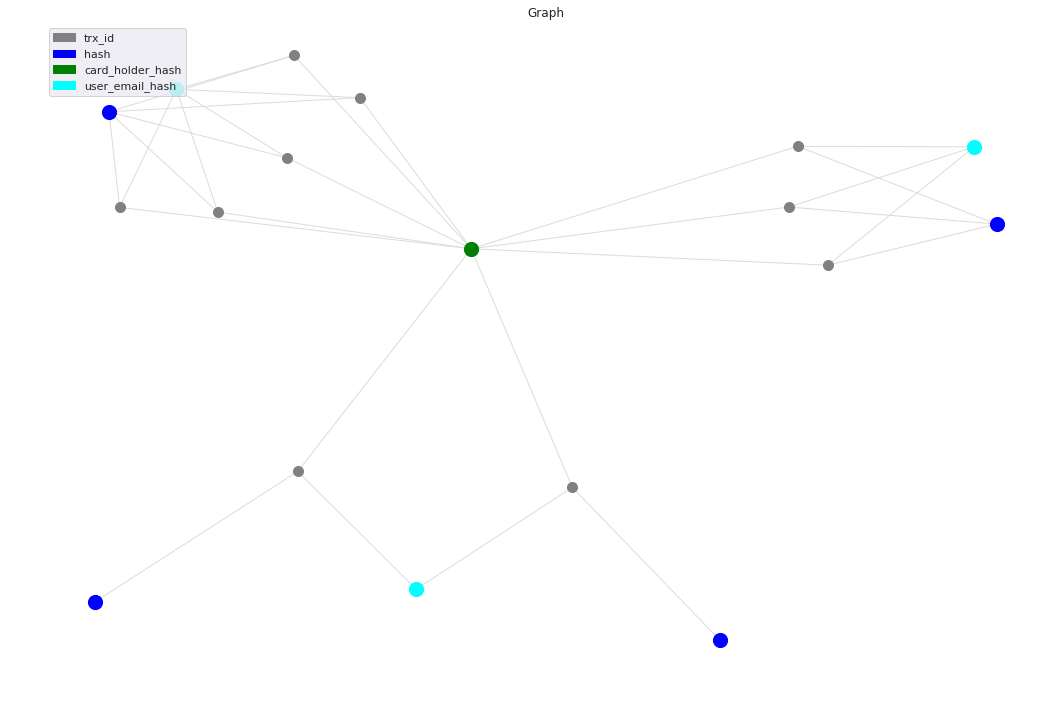

In [36]:
edge_columns = ['hash','card_holder_hash', 'user_email_hash']
edge_colors = ['blue','green','cyan']
pivot_column = 'trx_id'
pivot_color = 'gray'

_ = plot_graph(
    df_trx[df_trx.community_id == 758], 
    edge_columns, 
    pivot_column, 
    edge_colors, 
    pivot_color, 
    x_size=18, 
    y_size=12
)

### Community Detection by Agglomerative Methods

In [37]:
# Build graph
G_758 = build_graph(
    df_trx[df_trx.community_id == 758], 
    'trx_id', 
    ['hash','card_holder_hash', 'user_email_hash'], 
    ['is_fraud', 'amt'], 
    False
)

In [38]:
communities_generator = community.girvan_newman(G_758)
next_level_communities = next(communities_generator)
node_groups = sorted(map(sorted, next_level_communities))

In [39]:
node_groups

[['card_holder_hash-c76b3e5ddcf93fc6704207616adbdc192fed706d236269c7769da3633e6cb106',
  'hash-15d8fbe308ddcb48593c74476835d5a99036e3aed1442e5dc655b1e6c64955ae',
  'hash-380beeac22bf74d5e6920dd3d50a076ed4384c917c1022b9901d3f2f02e388bc',
  'trx_id-225656336',
  'trx_id-225657042',
  'trx_id-225657430',
  'trx_id-227533062',
  'trx_id-227534350',
  'trx_id-227535772',
  'trx_id-227537569',
  'trx_id-227538866',
  'user_email_hash-35cd752eb8d7d9a08289f4269b4bc9df1242fef52c05298882c116d4e7cd2861',
  'user_email_hash-761dc1dbbcd6cc51cf115ee1fa141c535f103696e0a24609cae61ee04cd5fd87'],
 ['hash-10f612f701a765fd7536d5affef3073ae088b770f4f90354bc0c4381df82e6e9',
  'hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563',
  'trx_id-251079006',
  'trx_id-252863074',
  'user_email_hash-80e85b23d15707ec8e88520ad476636e601142ba0de672e6f4c100ad8f8d2d54']]

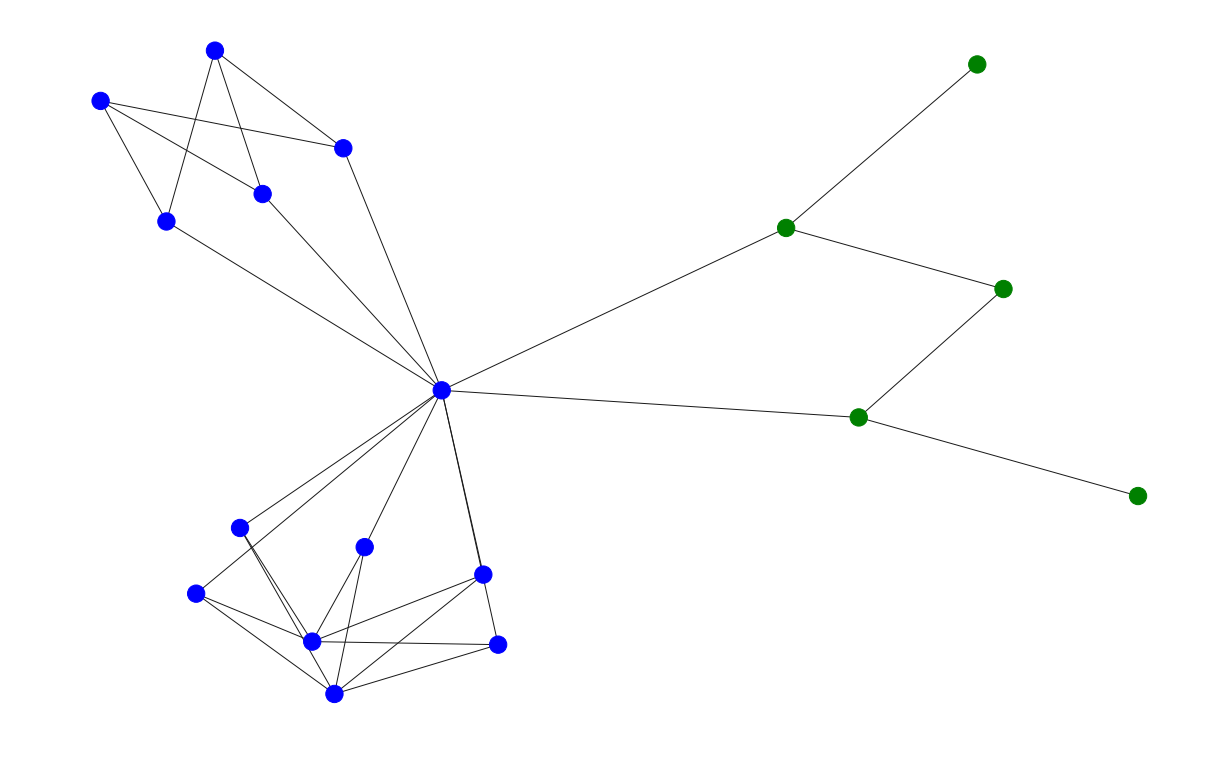

In [40]:
color_map = []
for node in G_758:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

plt.figure(figsize=(16, 10))
nx.draw(G_758, node_color=color_map, with_labels=False)
plt.show()

## Graph representations

Bellow you will find two ways to perform a compact representation of a graph; adjacency matrix and edge listing

Available NetworkX Algorithms:

https://networkx.org/documentation/networkx-1.10/reference/algorithms.html

### Adjacency matrix

The adjacency matrix of a graph is a square matrix that its element is 1 when there is an edge from node i to node j, and 0 when there is no edge.

In [41]:
nx.to_pandas_adjacency(G_758)

,trx_id-227535772,hash-15d8fbe308ddcb48593c74476835d5a99036e3aed1442e5dc655b1e6c64955ae,trx_id-227533062,trx_id-227538866,trx_id-225657430,hash-380beeac22bf74d5e6920dd3d50a076ed4384c917c1022b9901d3f2f02e388bc,trx_id-225657042,trx_id-251079006,hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563,trx_id-227537569,trx_id-227534350,trx_id-252863074,hash-10f612f701a765fd7536d5affef3073ae088b770f4f90354bc0c4381df82e6e9,trx_id-225656336,card_holder_hash-c76b3e5ddcf93fc6704207616adbdc192fed706d236269c7769da3633e6cb106,user_email_hash-35cd752eb8d7d9a08289f4269b4bc9df1242fef52c05298882c116d4e7cd2861,user_email_hash-761dc1dbbcd6cc51cf115ee1fa141c535f103696e0a24609cae61ee04cd5fd87,user_email_hash-80e85b23d15707ec8e88520ad476636e601142ba0de672e6f4c100ad8f8d2d54
trx_id-227535772,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
hash-15d8fbe308ddcb48593c74476835d5a99036e3aed1442e5dc655b1e6c64955ae,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
trx_id-227533062,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
trx_id-227538866,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
trx_id-225657430,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
hash-380beeac22bf74d5e6920dd3d50a076ed4384c917c1022b9901d3f2f02e388bc,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
trx_id-225657042,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
trx_id-251079006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
trx_id-227537569,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Edge List

As well as an adjacency matrix, an edge list is another compact way to represent graphs.
The idea behind this format is to represent a graph as a list of edges.

In [42]:
nx.to_pandas_edgelist(G_758)

,source,target
0,trx_id-227535772,hash-15d8fbe308ddcb48593c74476835d5a99036e3aed...
1,trx_id-227535772,card_holder_hash-c76b3e5ddcf93fc6704207616adbd...
2,trx_id-227535772,user_email_hash-35cd752eb8d7d9a08289f4269b4bc9...
3,hash-15d8fbe308ddcb48593c74476835d5a99036e3aed...,trx_id-227533062
4,hash-15d8fbe308ddcb48593c74476835d5a99036e3aed...,trx_id-227538866
5,hash-15d8fbe308ddcb48593c74476835d5a99036e3aed...,trx_id-227537569
6,hash-15d8fbe308ddcb48593c74476835d5a99036e3aed...,trx_id-227534350
7,trx_id-227533062,card_holder_hash-c76b3e5ddcf93fc6704207616adbd...
8,trx_id-227533062,user_email_hash-35cd752eb8d7d9a08289f4269b4bc9...
9,trx_id-227538866,card_holder_hash-c76b3e5ddcf93fc6704207616adbd...


## Graph properties - Integration Metrics

These measure how nodes tend to be interconnected with each other.

### Distance, path, and shortest path

The concept of distance in a graph is often related to the number of edges to traverse in order to reach a target node from a given source node.

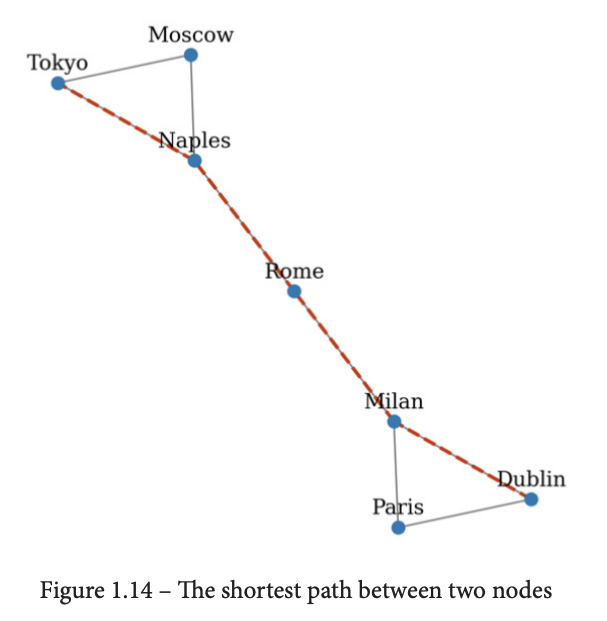

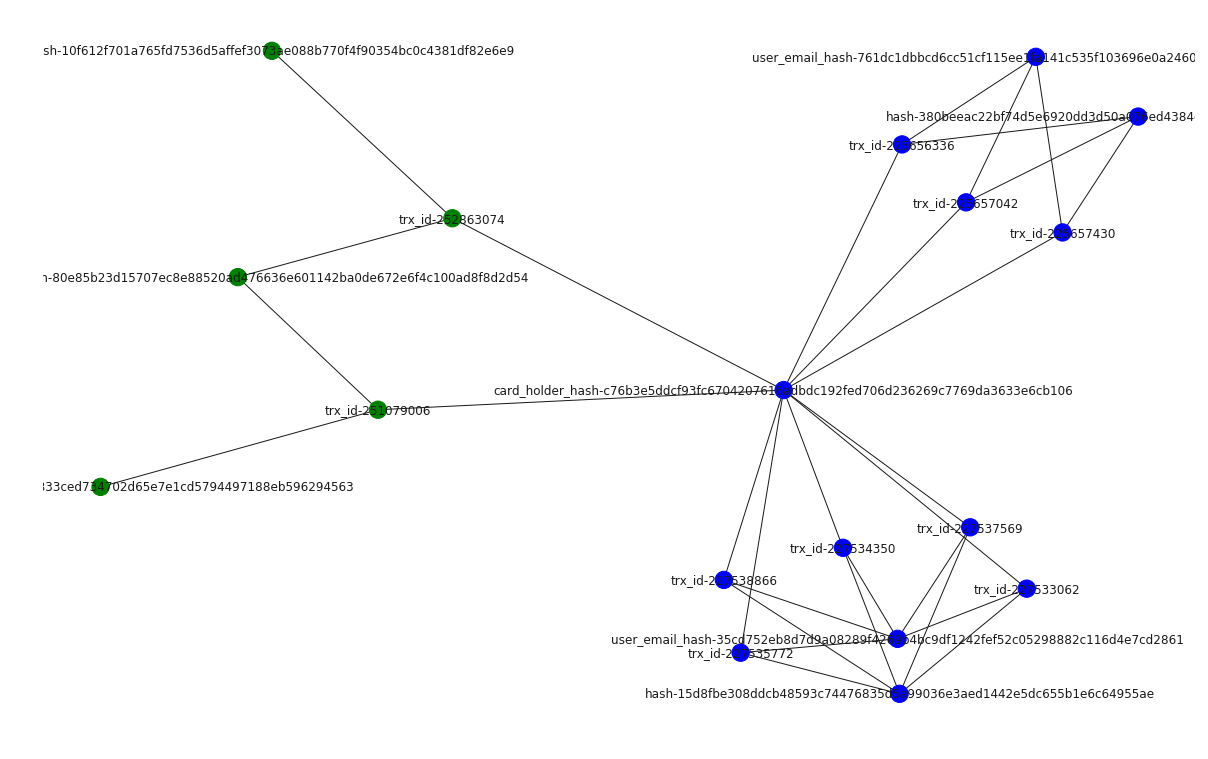

In [43]:
color_map = []
for node in G_758:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

plt.figure(figsize=(16, 10))
nx.draw(G_758, node_color=color_map, with_labels=True)
plt.show()

In [44]:
path = nx.shortest_path(
    G_758,
    source='hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563',
    target='user_email_hash-35cd752eb8d7d9a08289f4269b4bc9df1242fef52c05298882c116d4e7cd2861'
)

Shortest path from hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563 to user_email_hash-35cd752eb8d7d9a08289f4269b4bc9df1242fef52c05298882c116d4e7cd2861

In [45]:
path

['hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563',
 'trx_id-251079006',
 'card_holder_hash-c76b3e5ddcf93fc6704207616adbdc192fed706d236269c7769da3633e6cb106',
 'trx_id-227535772',
 'user_email_hash-35cd752eb8d7d9a08289f4269b4bc9df1242fef52c05298882c116d4e7cd2861']

In [46]:
print(f'Distance: {len(path)-1}')

Distance: 4


### Characteristic path length

The characteristic path length is defined as the average of all the shortest path lengths between all possible pair of nodes.

However, this metric cannot be always defined since it is not possible to compute a path among all the nodes in disconnected graphs. For this reason, network efficiency is also widely used.

In [47]:
nx.average_shortest_path_length(G_758)

2.3529411764705883

## Graph properties - Resilience metrics

There are several metrics that measure a network's resilience. Assortativity is one of the most used.

### Assortativity coefficient

Assortativity is used to quantify the tendency of nodes being connected to similar nodes.
There are several ways to measure such correlations. 
One of the most commonly used methods is the Pearson correlation coefficient between the degrees of directly connected nodes (nodes on two opposite ends of a link). 
The coefficient assumes positive values when there is a correlation between nodes of a similar degree, while it assumes negative values when there is a correlation between nodes of a different degree.

In [48]:
nx.degree_pearson_correlation_coefficient(G_758)

-0.278409090909091

Social networks are mostly assortative. However, the so-called influencers (famous singers, football players, fashion bloggers) tend to be followed (incoming edges) by several standard users, while tending to be connected with each other and showing a disassortative behavior.

## Graph properties - Centrality metrics

In the following section, we describe some of the most commonly used metrics that measure global and local properties.

### Degree centrality

One of the most common and simple centrality metrics is the degree centrality metric. 

This is directly connected with the degree of a node, measuring the number of incident edges on a certain node i.

In [49]:
nx.degree_centrality(G_758)

{'trx_id-227535772': 0.1764705882352941,
 'hash-15d8fbe308ddcb48593c74476835d5a99036e3aed1442e5dc655b1e6c64955ae': 0.29411764705882354,
 'trx_id-227533062': 0.1764705882352941,
 'trx_id-227538866': 0.1764705882352941,
 'trx_id-225657430': 0.1764705882352941,
 'hash-380beeac22bf74d5e6920dd3d50a076ed4384c917c1022b9901d3f2f02e388bc': 0.1764705882352941,
 'trx_id-225657042': 0.1764705882352941,
 'trx_id-251079006': 0.1764705882352941,
 'hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563': 0.058823529411764705,
 'trx_id-227537569': 0.1764705882352941,
 'trx_id-227534350': 0.1764705882352941,
 'trx_id-252863074': 0.1764705882352941,
 'hash-10f612f701a765fd7536d5affef3073ae088b770f4f90354bc0c4381df82e6e9': 0.058823529411764705,
 'trx_id-225656336': 0.1764705882352941,
 'card_holder_hash-c76b3e5ddcf93fc6704207616adbdc192fed706d236269c7769da3633e6cb106': 0.5882352941176471,
 'user_email_hash-35cd752eb8d7d9a08289f4269b4bc9df1242fef52c05298882c116d4e7cd2861': 0.2941176470588235

### Closeness centrality

The closeness centrality metric attempts to quantify how much a node is close (well connected) to other nodes. 

More formally, it refers to the average distance of a node to all other nodes in the network.

In [50]:
nx.closeness_centrality(G_758)

{'trx_id-227535772': 0.4722222222222222,
 'hash-15d8fbe308ddcb48593c74476835d5a99036e3aed1442e5dc655b1e6c64955ae': 0.38636363636363635,
 'trx_id-227533062': 0.4722222222222222,
 'trx_id-227538866': 0.4722222222222222,
 'trx_id-225657430': 0.4722222222222222,
 'hash-380beeac22bf74d5e6920dd3d50a076ed4384c917c1022b9901d3f2f02e388bc': 0.3541666666666667,
 'trx_id-225657042': 0.4722222222222222,
 'trx_id-251079006': 0.4722222222222222,
 'hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563': 0.3269230769230769,
 'trx_id-227537569': 0.4722222222222222,
 'trx_id-227534350': 0.4722222222222222,
 'trx_id-252863074': 0.4722222222222222,
 'hash-10f612f701a765fd7536d5affef3073ae088b770f4f90354bc0c4381df82e6e9': 0.3269230769230769,
 'trx_id-225656336': 0.4722222222222222,
 'card_holder_hash-c76b3e5ddcf93fc6704207616adbdc192fed706d236269c7769da3633e6cb106': 0.7083333333333334,
 'user_email_hash-35cd752eb8d7d9a08289f4269b4bc9df1242fef52c05298882c116d4e7cd2861': 0.38636363636363635,
 

### Betweenness centrality

The betweenness centrality metric evaluates how much a node acts as a bridge between other nodes. 

Even if poorly connected, a node can be strategically connected, helping to keep the whole network connected.

In [51]:
nx.betweenness_centrality(G_758)

{'trx_id-227535772': 0.03382352941176471,
 'hash-15d8fbe308ddcb48593c74476835d5a99036e3aed1442e5dc655b1e6c64955ae': 0.024509803921568624,
 'trx_id-227533062': 0.03382352941176471,
 'trx_id-227538866': 0.03382352941176471,
 'trx_id-225657430': 0.06617647058823528,
 'hash-380beeac22bf74d5e6920dd3d50a076ed4384c917c1022b9901d3f2f02e388bc': 0.007352941176470588,
 'trx_id-225657042': 0.06617647058823528,
 'trx_id-251079006': 0.16544117647058823,
 'hash-d7b05ff3cb4970582cb494833ced734702d65e7e1cd5794497188eb596294563': 0.0,
 'trx_id-227537569': 0.03382352941176471,
 'trx_id-227534350': 0.03382352941176471,
 'trx_id-252863074': 0.16544117647058823,
 'hash-10f612f701a765fd7536d5affef3073ae088b770f4f90354bc0c4381df82e6e9': 0.0,
 'trx_id-225656336': 0.06617647058823528,
 'card_holder_hash-c76b3e5ddcf93fc6704207616adbdc192fed706d236269c7769da3633e6cb106': 0.7450980392156862,
 'user_email_hash-35cd752eb8d7d9a08289f4269b4bc9df1242fef52c05298882c116d4e7cd2861': 0.024509803921568624,
 'user_email_hash

# Graph Data Science

## Embeddings

An embedding is a mapping of a discrete (categorical) variable to a vector of continuous numbers. In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space.

Additional reading https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526

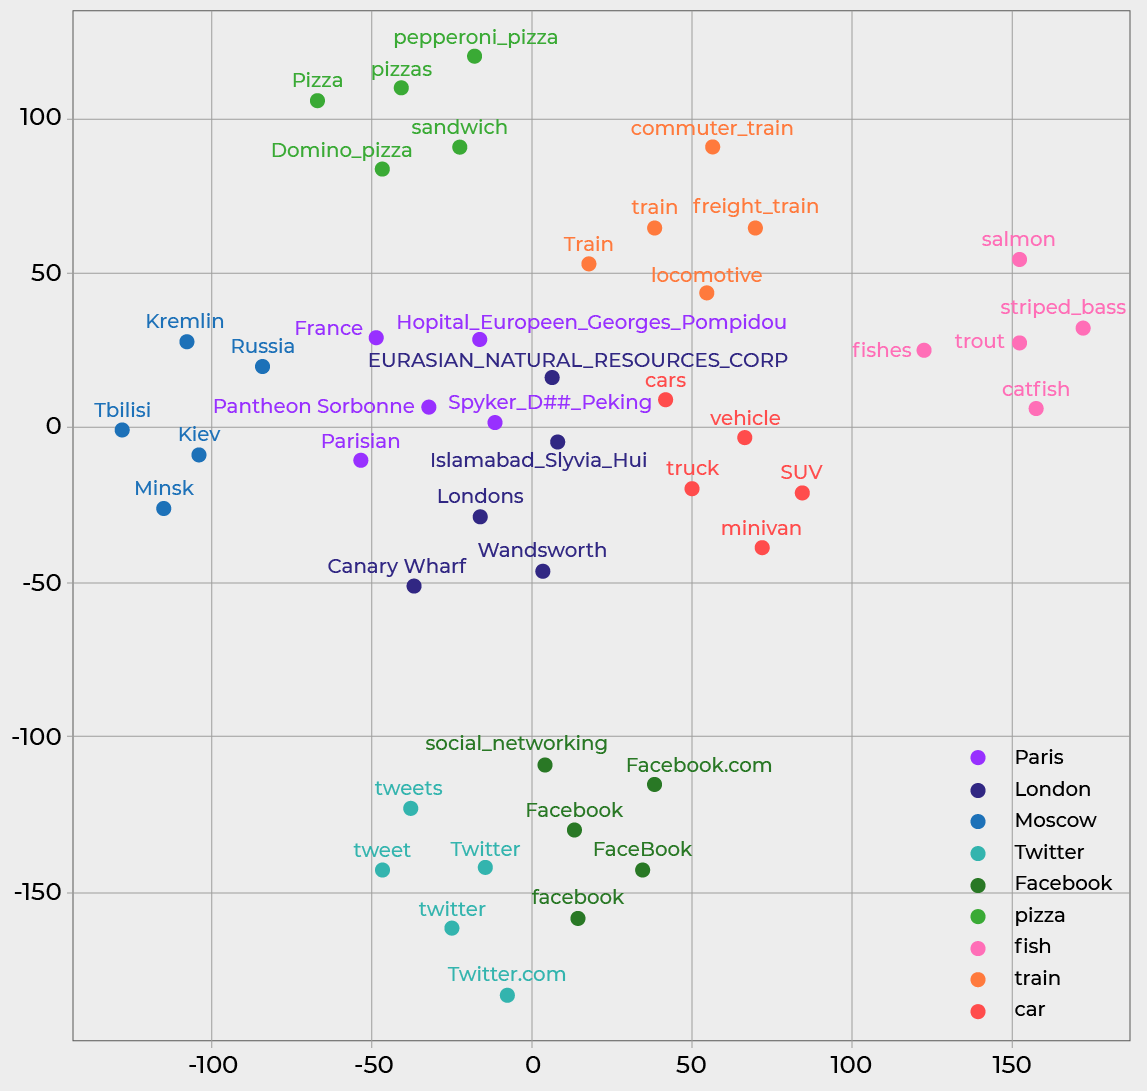

## Graph Embeddings

Graph embeddings are the transformation of property graphs to a vector or a set of vectors. 

Embedding should capture the graph topology, vertex-to-vertex relationship, and other relevant information about graphs, subgraphs, and vertices. 

More properties embedder encode better results can be retrieved in later tasks.

Graph Embeddings Summary: https://towardsdatascience.com/graph-embeddings-the-summary-cc6075aba007

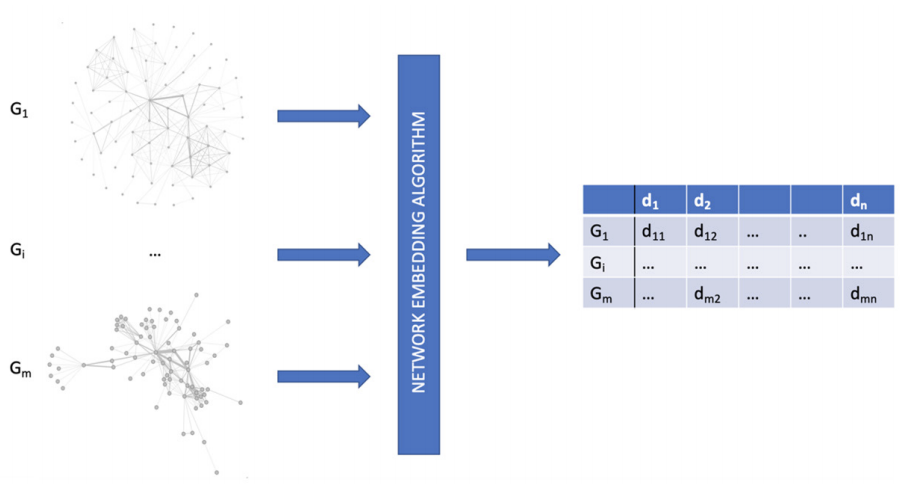

Many algorithms have been developed in relation to unsupervised graph machine learning techniques:

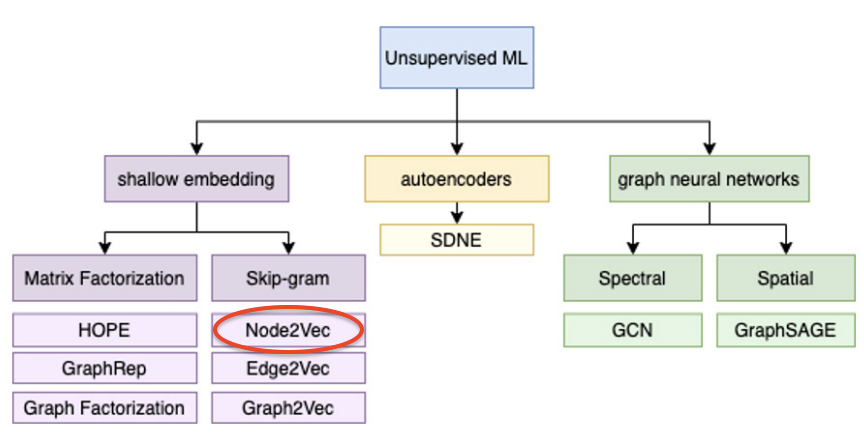

node2vec aims to create embeddings for nodes in a graph (in the G(V, E, W) sense of the word).

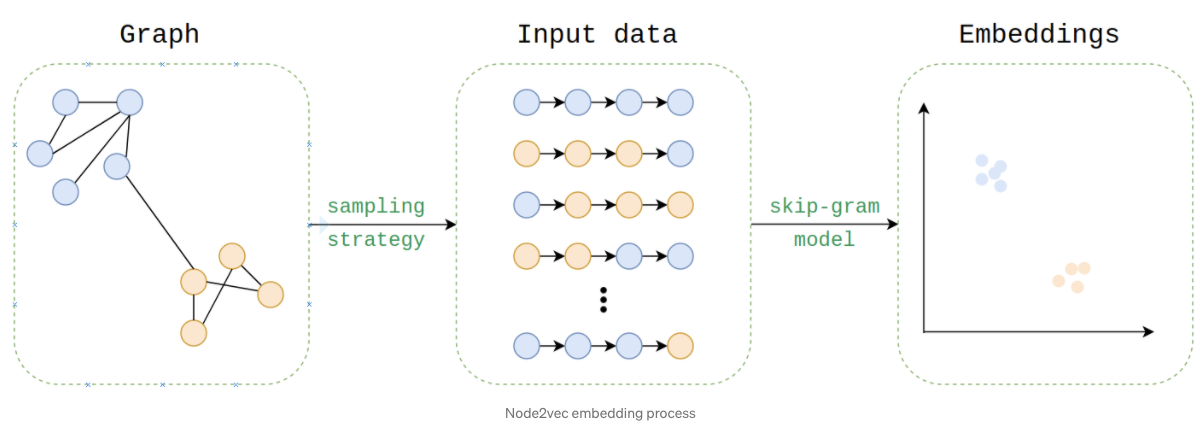

More details regarding Node2Vec Algorithm can be found here: https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef

node2vec: Scalable Feature Learning for Networks https://arxiv.org/abs/1607.00653

In [52]:
n_dimensions = 2
embd_col_names = ['embedding'+str(x) for x in range(1,n_dimensions+1)]

df_embeddings = pd.DataFrame(columns=['trx_id', 'embedding'] + embd_col_names)

bad_comm = list(df_community[(df_community.ratio_cbk_q > 0)].community_id.unique())
good_com = df_community[(df_community.ratio_cbk_q == 0)].head(50).community_id.to_list()

# Build graph
G, sG = build_graph(
    df_trx[df_trx.community_id.isin(bad_comm + good_com)], 
    'trx_id', 
    ['hash','card_holder_hash', 'user_email_hash'], 
    ['is_fraud', 'amt'], 
    True
)

for subgraph in sG:
    
    # Node2vec
    node2vec = Node2Vec(
        subgraph, 
        dimensions=n_dimensions, 
        walk_length=10, 
        num_walks=5
    )
    
    # Embed nodes
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    # Get embeddings for each node
    sG_nodes = subgraph.nodes
    sG_nodes_trx_id = [int(node.replace('trx_id-','')) for node in sG_nodes if node.startswith('trx_id')]
    trx_id_embeddings = [list(model.wv['trx_id-'+str(node)]) for node in sG_nodes_trx_id]
    
    df_embeddings_temp = pd.DataFrame(
        list(zip(sG_nodes_trx_id, trx_id_embeddings)), 
        columns=['trx_id','embedding']
    )
    df_embeddings_split = pd.DataFrame(df_embeddings_temp['embedding'].to_list(), columns=embd_col_names)
    df_embeddings_temp = pd.concat([df_embeddings_temp, df_embeddings_split], axis=1)
    df_embeddings = df_embeddings.append(df_embeddings_temp, ignore_index=True)

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:00<00:00, 193.85it/s]


In [53]:
df_trx_emb = df_trx.merge(df_embeddings, on='trx_id')

In [54]:
df_trx_emb.head()

,trx_id,created_date,amt,hash,card_holder_hash,user_email_hash,is_fraud,cbk_date_created,amt_cbk,community_id,embedding,embedding1,embedding2
0,65957973,2020-02-19 00:06:36,4.43,ecb8705d4298321527f850da457f18b0e70814354e588c...,280c26070fadf68639172163036d5f7cbb2421565ea105...,30d332a51aa8e6be35301e323f6d7adacf6a78b89d47ce...,0,NaT,0.0,1,"[0.25838107, -0.0468999]",0.258381,-0.046900
1,68511121,2020-02-29 15:45:58,43.23,108a4cf43b3649b07744f01ae3788d23e3fbf3e8eb4a35...,87c100ab345e7d87934896d47267d2cff359a0bd7e2a48...,e95f92d5fd98d7ba95c148ee17f17023551734fd542a0d...,0,NaT,0.0,2,"[1.0600842, -0.7926521]",1.060084,-0.792652
2,68992833,2020-03-02 10:59:05,2.16,13bfdf285ed294dda86ce3dd14cdf4cb1f2a3d9176b27c...,a0c98f149bdd6cfe2fe486babf2e99c1906bbf07be92f8...,28ee1f28f93bdde2bcb86a2d41deb85f69609f637efc08...,0,NaT,0.0,3,"[0.31653327, -0.7966795]",0.316533,-0.796679
3,72375752,2020-03-16 12:32:24,0.60,2f1886a4ef54bd62b57af5a1c41b67d2d6471de1c28df4...,c12fa75fdb144ad3fd42d11c3dbce7063878452cc8f0cd...,c9131080340b3988e4e14f6cbc405ca6db3ecb221f4a58...,0,NaT,0.0,7,"[-0.017391091, -0.26066694]",-0.017391,-0.260667
4,76403217,2020-04-01 14:26:49,9.24,7df7a9d856bbe983785eaf97ae897051da98066f4bda3a...,73237bd40c36e186eccc797b1b351eb2258b2cc40f4f4f...,f43a713948de232fa2809cca4313b4307905f35dc60b73...,0,NaT,0.0,10,"[-0.17904843, -0.14102413]",-0.179048,-0.141024


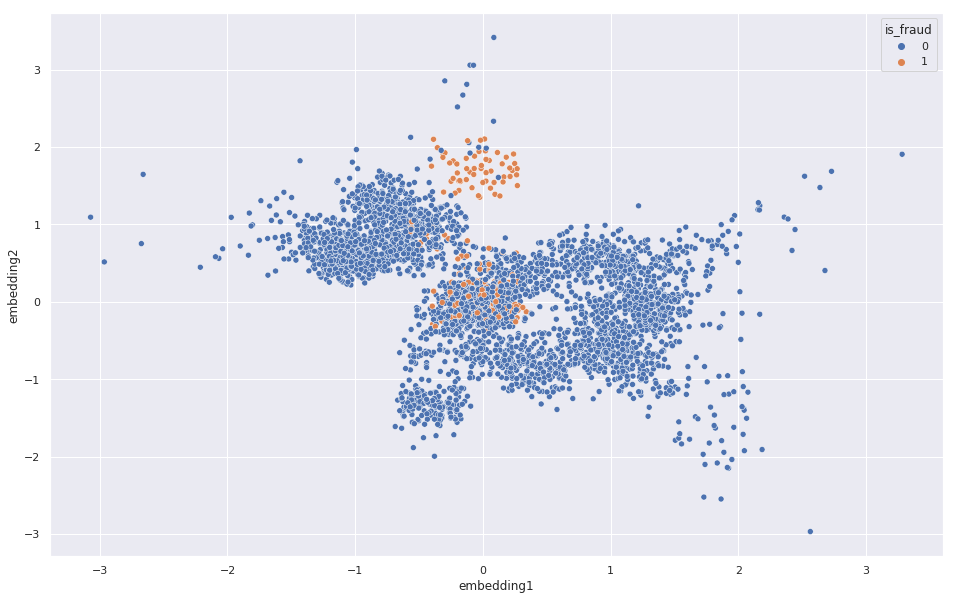

In [55]:
sns.set(rc={'figure.figsize':(16, 10)})

g = sns.scatterplot(
    data = df_trx_emb,
    x = "embedding1",
    y = "embedding2",
    hue='is_fraud'
)

## Model Training

Let's sort the transaction dataframe by datetime, so we can simulate incoming trx and graph calculations

In [56]:
df_trx = df_trx.sort_values(by='created_date')
df_trx.reset_index(inplace=True, drop=True)

### Generate Graph Embeddings

Below we are going to simulate incoming transactions and graph embedding.

So for each trx, we have to build the graph and extract the embedding for it. Here lays on of the main challenge with GDS.

In [57]:
def get_embedding_for_trx(df_trx, trx_id, created_date, n_dimensions=10):
    
    # Filter trx
    df = df_trx[
        (df_trx.trx_id <= trx_id) & 
        (df_trx.created_date >= pd.to_datetime(created_date) - timedelta(days=15))
    ]

    # Build graph
    G = build_graph(
        df, 
        'trx_id', 
        ['hash', 'card_holder_hash', 'user_email_hash'], 
        ['amt'], 
        False
    )

    # Identify nodes related to trx_id and build Subgraph
    nodes = nx.shortest_path(G,f'trx_id-{trx_id}').keys()
    sG = G.subgraph(nodes)

    # Node2vec
    node2vec = Node2Vec(
        sG, 
        dimensions=n_dimensions, 
        walk_length=10, 
        num_walks=5,
        quiet=True
    )

    # Embed nodes
    model = node2vec.fit(window=10)

    # Get embeddings for node
    embedding_values = list(model.wv['trx_id-'+str(trx_id)])
    
    return embedding_values

In [ ]:
dict_embeddings = {}

# First 15 days are left out due to cold start
trx_id_to_process = df_trx.created_date.min() + timedelta(days=15)

# Iterate over each trx, build graph and get embeddings
for index, row in tqdm(df_trx[df_trx.created_date >= trx_id_to_process].iterrows(), total=df_trx[df_trx.created_date >= trx_id_to_process].shape[0]):
    dict_embeddings[row['trx_id']] = get_embedding_for_trx(df_trx, row['trx_id'], row['created_date'])

In [ ]:
# Add embeddings to dataframe
df_trx['embeddings'] = df_trx.trx_id.map(dict_embeddings)

# Keep only trx usefull for training
df_trx_embedding = df_trx[~df_trx.embeddings.isnull()]
df_trx_embedding.reset_index(inplace=True, drop=True)

In [ ]:
df_trx_embedding.head()

In [ ]:
# Split embeddings list into columns to train model
n_dimensions = 10
embd_col_names = ['embedding'+str(x) for x in range(1,n_dimensions+1)]
df_embeddings_split = pd.DataFrame(df_trx_embedding['embeddings'].to_list(), columns=embd_col_names)
df_trx_embedding = pd.concat([df_trx_embedding, df_embeddings_split], axis=1)

In [ ]:
df_trx_embedding.head()

In [ ]:
# Save dataset (backup)
datetime_str = datetime.now().strftime("%Y%m%d_%H%M%S")
df_trx_embedding.to_parquet(f'data/df_trx_embedding_{datetime_str}.parquet')

print(f'data/df_trx_embedding_{datetime_str}.parquet')

### Load Graph Embeddings

As calculating the embeddigns takes time, we'll use one pre-trained.

In [58]:
df_trx_embedding = pd.read_parquet(f'data/df_trx_embedding_20220113_170620.parquet')

In [59]:
df_trx_embedding.head()

,trx_id,created_date,amt,hash,card_holder_hash,user_email_hash,is_fraud,cbk_date_created,amt_cbk,community_id,...,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6,embedding7,embedding8,embedding9,embedding10
0,58704486,2020-01-16 04:10:47,88.89,857826f388edef759722871b5eab0fa476b91e6022e689...,5e0eb6d3fb61cc52ad90eb829e2da8a708ad9c0769c2cf...,ad5f69354fda276dd9d68290f8d3669ed4a445f2bb1bd0...,0,NaT,0.00,6863,...,-0.025879,-0.007160,-0.014676,-0.025187,0.035245,-0.037055,0.034418,0.010912,0.032331,0.032839
1,58729005,2020-01-16 10:59:55,16.18,9217813a8a306480a9d093c8f78f86f7dc8fa3d4310966...,dd1504e0cb1d00a0ae918f77ff82ca5d468a6685a85c40...,1b4cb73a267ec3b1cf97bcde595746674d625f4fadd2d5...,0,NaT,0.00,5614,...,-0.041622,-0.023113,0.001233,0.038617,0.018212,0.008352,0.024861,0.026306,0.009067,0.032810
2,58789726,2020-01-16 16:39:10,25.43,0485680acf53ba1b9ed9cc4cb726fe24d4d5da75989ee8...,750bd7ca38c2cafb38b76edd5e50851f169832e6e67ea2...,a4246e59225eec0349a86f41a6c841ef2354290316383b...,1,2020-01-30 19:58:19,25.43,5079,...,0.038721,0.019622,0.014345,-0.041045,0.042151,-0.023700,0.030020,-0.041967,0.033372,-0.039151
3,58813989,2020-01-16 18:30:44,11.53,4d6f7b7f9928f9e55be568cb49440719ed6b2c507e576d...,1d74465069717bf4acf66e456182a106e400ec1dc80c92...,171b350e93154b567979f750fc0c13c1fb412b4e06c6c5...,0,NaT,0.00,3938,...,0.049775,-0.009333,0.026160,0.030240,-0.040068,0.016276,-0.017369,-0.016492,-0.030266,0.034166
4,58832853,2020-01-16 20:32:26,34.55,fcf2185ac85a9fd695d4f06b519f88e53d908ac8ef7915...,b53297a573f2da120890a9f4f41e3964c4dc24aafb1e05...,b35f03400d1fcf81007933d1f6dcb6926597da0e7d7065...,0,NaT,0.00,795,...,-0.016237,0.020657,0.045682,-0.042929,-0.025657,0.031407,0.044683,0.005729,0.044165,0.036368


### Features

Let's use only the embeddings plus the amount to train our model.

In [60]:
important_variables = [
    'amt',
    'embedding1', 
    'embedding2',
    'embedding3', 
    'embedding4', 
    'embedding5', 
    'embedding6', 
    'embedding7',
    'embedding8', 
    'embedding9', 
    'embedding10'
]
important_variables.sort()

### Split dataset into training and testing

As the intention of this workshop was to show how we can use graph on ML, to simplify we are gonna use only two datasets. The best approach would be leaving a holdout dataset for final evaluation.

In [61]:
dataset_train = df_trx_embedding[(df_trx_embedding.created_date < '2021-08-01')]

print('Train Dataset Time Window: {} - {}'.format(dataset_train['created_date'].min(),dataset_train['created_date'].max()))
print('Train Dataset Length: {}'.format(len(dataset_train)))
print('Train Dataset Columns: {}'.format(len(dataset_train.columns)))
print('Positive class: {} ({}%)'.format(np.sum(dataset_train['is_fraud']==1), np.round(100*np.sum(dataset_train['is_fraud']==1)/len(dataset_train),2)))
print('Negative class: {} ({}%)'.format(np.sum(dataset_train['is_fraud']==0), np.round(100*np.sum(dataset_train['is_fraud']==0)/len(dataset_train),2)))

Train Dataset Time Window: 2020-01-16 04:10:47 - 2021-07-31 23:59:20
Train Dataset Length: 17704
Train Dataset Columns: 21
Positive class: 1205 (6.81%)
Negative class: 16499 (93.19%)


In [62]:
dataset_test = df_trx_embedding[
    (df_trx_embedding.created_date >= '2021-08-01') & (df_trx_embedding.created_date < '2021-12-01')]

print('Test Dataset Time Window: {} - {}'.format(dataset_test['created_date'].min(),dataset_test['created_date'].max()))
print('Test Dataset Length: {}'.format(len(dataset_test)))
print('Test Dataset Columns: {}'.format(len(dataset_test.columns)))
print('Positive class: {} ({}%)'.format(np.sum(dataset_test['is_fraud']==1), np.round(100*np.sum(dataset_test['is_fraud']==1)/len(dataset_test),2)))
print('Negative class: {} ({}%)'.format(np.sum(dataset_test['is_fraud']==0), np.round(100*np.sum(dataset_test['is_fraud']==0)/len(dataset_test),2)))

Test Dataset Time Window: 2021-08-01 00:13:24 - 2021-11-30 23:24:02
Test Dataset Length: 3282
Test Dataset Columns: 21
Positive class: 214 (6.52%)
Negative class: 3068 (93.48%)


### Model training

In [63]:
import sklearn
import numpy as np

def binarize(label_array):
    binary_array = [None] * len(label_array)
    for i in range(0,len(label_array)):
        if label_array[i] == 0:
            binary_array[i] = [1,0]
        else:
            binary_array[i] = [0,1]
    return np.array(binary_array)

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def get_kpis(Y_test,prediction_array):
    #y_score = prediction_array[0]
    Y_test = binarize(Y_test.values)

    n_classes = 2
    precision = dict()
    recall = dict()
    average_precision = dict()
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 
                    'cornflowerblue', 'teal','salmon',
                    'darkmagenta','olive', 'crimson'])

    plt.figure(figsize=(12, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')

    for pred_idx in range(len(prediction_array)):
        y_score = prediction_array[pred_idx]
        for i, color in zip(range(n_classes), colors):
            if i == 1:
                precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                                y_score[:, i])
                average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])
                l, = plt.plot(recall[i], precision[i], color=color, lw=2)
                lines.append(l)
                labels.append('PRC for Fraud (area = {0:0.2f})'
                              ''.format(average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to Fraud class')
    plt.legend(lines, labels, loc=(1.05, 0), prop=dict(size=14))


    plt.show()
    
def get_prerec_avg_vals(pred_arr,true_vals):
    for i in range(1,6):
        precisions = []
        thresholds_arr = []
        print('current recall: {}'.format(i/10*100))
        for j in range(len(pred_arr)):
            precision,recall,thresholds = precision_recall_curve(binarize(true_vals.values)[:, 1], 
                                                        pred_arr[j][:, 1])

            recall_pos = np.where(recall >= i/10)[0][-1]
            precisions.append(precision[recall_pos])
            thresholds_arr.append(thresholds[recall_pos])
        print('average precision: {}'.format((np.sum(precisions) / len(precisions))*100))
        print('standard deviation: {}'.format(np.std(precisions, dtype=np.float64)*100))
        print('average false-positive rate: {}'.format(1/(np.sum(precisions) / len(precisions))))
        print('average false-positive rate + std: {}'.format(1/((np.sum(precisions) / len(precisions)) - np.std(precisions, dtype=np.float64))))
        print('average false-positive rate - std: {}'.format(1/((np.sum(precisions) / len(precisions)) + np.std(precisions, dtype=np.float64))))       
        print('average false-positive rate + 2 std: {}'.format(1/((np.sum(precisions) / len(precisions)) - 2 * np.std(precisions, dtype=np.float64))))
        print('average false-positive rate - 2 std: {}'.format(1/((np.sum(precisions) / len(precisions)) + 2 * np.std(precisions, dtype=np.float64))))       
        print('average threshold: {}'.format((np.sum(thresholds_arr) / len(thresholds_arr))*1000))
        
def get_bussiness_kpis(pred_arr,true_vals):
    print('total cases: {}'.format(len(true_vals)))
    total_frd = len(true_vals[true_vals == 1])
    print('total fraud: {}'.format(total_frd))
    for i in range(1,11):
        precisions = []
        thresholds_arr = []
        print('------------------------------'.format(i/10*100))
        print('current recall: {}%'.format(i/10*100))
        for j in range(len(pred_arr)):
            precision,recall,thresholds = precision_recall_curve(binarize(true_vals.values)[:, 1], 
                                                        pred_arr[j][:, 1])

            recall_pos = np.where(recall >= i/10)[0][-1]
            precisions.append(precision[recall_pos])
            thresholds_arr.append(thresholds[recall_pos])
        print('rejection rate: {0:0.2f}%'.format( ((i/10*total_frd)*(1/(np.sum(precisions) / len(precisions))) / len(true_vals) * 100)))
        print('average precision: {0:0.2f}%'.format((np.sum(precisions) / len(precisions))*100))
        print('average false-positive rate: {0:0.2f}'.format(1/(np.sum(precisions) / len(precisions))))
        print('average threshold: {0:0.2f}'.format((np.sum(thresholds_arr) / len(thresholds_arr))*1000))        

[0]	validation_0-aucpr:0.56845	validation_1-aucpr:0.12651
[1]	validation_0-aucpr:0.57091	validation_1-aucpr:0.12521
[2]	validation_0-aucpr:0.57586	validation_1-aucpr:0.12765
[3]	validation_0-aucpr:0.57815	validation_1-aucpr:0.12646
[4]	validation_0-aucpr:0.57863	validation_1-aucpr:0.12660
[5]	validation_0-aucpr:0.59808	validation_1-aucpr:0.12431
[6]	validation_0-aucpr:0.61129	validation_1-aucpr:0.12171
[7]	validation_0-aucpr:0.62734	validation_1-aucpr:0.12093
[8]	validation_0-aucpr:0.62968	validation_1-aucpr:0.12041
[9]	validation_0-aucpr:0.63535	validation_1-aucpr:0.12074
[10]	validation_0-aucpr:0.64291	validation_1-aucpr:0.13378
[11]	validation_0-aucpr:0.65014	validation_1-aucpr:0.12590
[12]	validation_0-aucpr:0.65725	validation_1-aucpr:0.13240
[13]	validation_0-aucpr:0.66313	validation_1-aucpr:0.13297
[14]	validation_0-aucpr:0.66694	validation_1-aucpr:0.13930
[15]	validation_0-aucpr:0.67317	validation_1-aucpr:0.14594
[16]	validation_0-aucpr:0.67818	validation_1-aucpr:0.14559
[17]	va

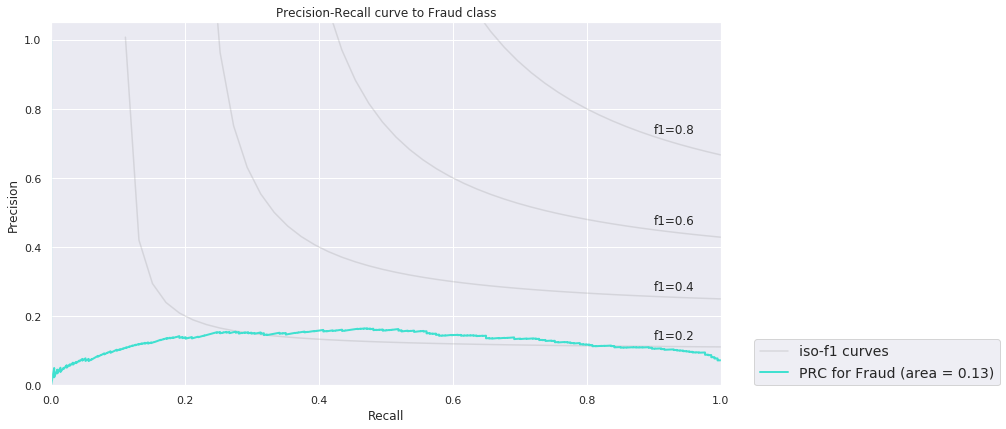

total cases: 3282
total fraud: 214
------------------------------
current recall: 10.0%
rejection rate: 6.25%
average precision: 10.43%
average false-positive rate: 9.59
average threshold: 151.03
------------------------------
current recall: 20.0%
rejection rate: 9.37%
average precision: 13.92%
average false-positive rate: 7.19
average threshold: 117.74
------------------------------
current recall: 30.0%
rejection rate: 12.91%
average precision: 15.15%
average false-positive rate: 6.60
average threshold: 93.49
------------------------------
current recall: 40.0%
rejection rate: 16.41%
average precision: 15.90%
average false-positive rate: 6.29
average threshold: 76.91
------------------------------
current recall: 50.0%
rejection rate: 20.48%
average precision: 15.92%
average false-positive rate: 6.28
average threshold: 63.02
------------------------------
current recall: 60.0%
rejection rate: 26.84%
average precision: 14.58%
average false-positive rate: 6.86
average threshold: 48.30

In [64]:
prediction_array_cv = []
random_state = 5
eta = 0.2
depth = 5

q_positive_class = np.sum(dataset_train['is_fraud'] == 1)
q_negative_class = np.sum(dataset_train['is_fraud'] == 0)
weight = q_negative_class/q_positive_class

clf = XGBClassifier(
    eta = eta, 
    gamma = 0, 
    max_depth = depth, 
    reg_lambda = 2, 
    alpha = 1, 
    scale_pos_weight = 1, 
    eval_metric = 'aucpr', 
    subsample = 0.8, 
    random_state = random_state, 
    n_estimators = 80
)

clf = clf.fit(dataset_train[important_variables], 
              dataset_train['is_fraud'], 
              eval_set=[
                  (dataset_train[important_variables], dataset_train['is_fraud']), 
                  (dataset_test[important_variables], dataset_test['is_fraud'])
              ],
              verbose=True)

predictions = clf.predict_proba(dataset_test[important_variables])
prediction_array_cv.append(predictions)

get_kpis(dataset_test['is_fraud'],prediction_array_cv)  
get_bussiness_kpis(prediction_array_cv, dataset_test['is_fraud'])

### Save Model

In [ ]:
from joblib import dump, load
dump(clf, f'model/graph-model-{datetime_str}.joblib')